In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score

from tdamapper.core import MapperAlgorithm
from tdamapper.cover import CubicalCover
from tdamapper.plot import MapperLayoutInteractive
from tdamapper.clustering import FailSafeClustering
from sklearn import metrics

from chi import *
from functions import *
from regressionP import *

In [2]:
dataA1 = pd.read_csv("./Data/NPA_TMA1.csv")[:-2]

In [21]:
def preprocess(input_data, select_lst, sample = 592):
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)#.sample(sample).reset_index(drop=True)
    # sample_data = sample_data[sample_data['發生月份'] < 3]
    dataA = sample_data[select_lst]
    
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df, sample_data

# List of columns to select
select_lst = [
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者', #'道路障礙-視距品質名稱', # 和速限共線
    # '道路型態大類別名稱', # 和事故位置共線
    '事故位置大類別名稱', 
    # '路面狀況-路面鋪裝名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', # 分類幾乎都是無缺陷
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
    '死亡受傷人數',
    '經度', '緯度',
]

dist_dfA1 = preprocess(dataA1, select_lst, sample = 592)

rbind_data = pd.concat([dist_dfA1[0]], axis=0, ignore_index=True)

rbind_data.loc[rbind_data['受傷'] > 1, '受傷'] = 2
rbind_data['速限-第1當事者'] = rbind_data['速限-第1當事者'].apply(lambda x: 1 if x > 60 else 0)
# 顏色處理
rbind_data['color'] = rbind_data['速限-第1當事者'].astype(str) + rbind_data['事故位置大類別名稱']
# 標籤
dist_df = process_data(rbind_data)
scaler = StandardScaler()

full_dist = pd.DataFrame(scaler.fit_transform(dist_df), columns = dist_df.columns)
X1 = full_dist.drop(['受傷', '死亡', '經度', '緯度', 'color'], axis=1).to_numpy()

full_dist.head()

,光線名稱,道路類別-第1當事者-名稱,速限-第1當事者,事故位置大類別名稱,號誌-號誌種類名稱,車道劃分設施-分向設施大類別名稱,車道劃分設施-分道設施-快車道或一般車道間名稱,車道劃分設施-分道設施-快慢車道間名稱,車道劃分設施-分道設施-路面邊線名稱,事故類型及型態大類別名稱,經度,緯度,死亡,受傷,color
0,0.210590,1.156038,-0.372104,0.169821,-0.544820,-1.122302,1.616064,-1.397714,-0.666260,1.380786,-0.487862,-1.582274,-0.162392,-0.667536,-0.117067
1,1.522900,-0.585373,-0.372104,-1.216859,3.038885,-1.122302,-0.888412,-1.397714,-0.666260,-0.206448,1.224667,1.159946,-0.162392,0.900644,-1.086351
2,-1.101719,1.736509,-0.372104,0.863162,-0.544820,1.459574,0.989945,-1.397714,-0.666260,1.380786,-2.278252,-0.391081,-0.162392,-0.667536,0.367575
3,-1.101719,-0.585373,-0.372104,-1.216859,3.038885,-0.261677,-0.888412,0.457548,1.500915,-0.206448,1.052954,1.200310,-0.162392,0.900644,-1.086351
4,1.522900,1.156038,-0.372104,0.863162,-0.544820,0.598949,-0.888412,0.457548,-0.666260,1.380786,1.931796,0.399887,-0.162392,-0.667536,0.367575


In [12]:
# dist_df.head(12)#[dist_df['事故類型及型態大類別名稱'] == 0]

In [42]:
# rbind_data.head(12)#[(rbind_data['事故類型及型態大類別名稱'] == '人與車') & (rbind_data['速限-第1當事者'] == 0)]

In [6]:
count_data = rbind_data.groupby(['速限-第1當事者', '事故類型及型態大類別名稱']).size().unstack(fill_value=0)

total_count = count_data.sum(axis=1)
proportion_data = count_data.div(total_count, axis=0)
proportion_data

事故類型及型態大類別名稱,人與車,車與車,車輛本身
速限-第1當事者,,,
0,0.151923,0.569231,0.278846
1,0.069444,0.708333,0.222222


In [7]:
count_data = rbind_data.groupby(['速限-第1當事者', '事故位置大類別名稱']).size().unstack(fill_value=0)

total_count = count_data.sum(axis=1)
proportion_data = count_data.div(total_count, axis=0)
proportion_data

事故位置大類別名稱,交叉路口,交流道,其他,路段
速限-第1當事者,,,,
0,0.419231,0.001923,0.050000,0.528846
1,0.222222,0.041667,0.013889,0.722222


0.4842529296875


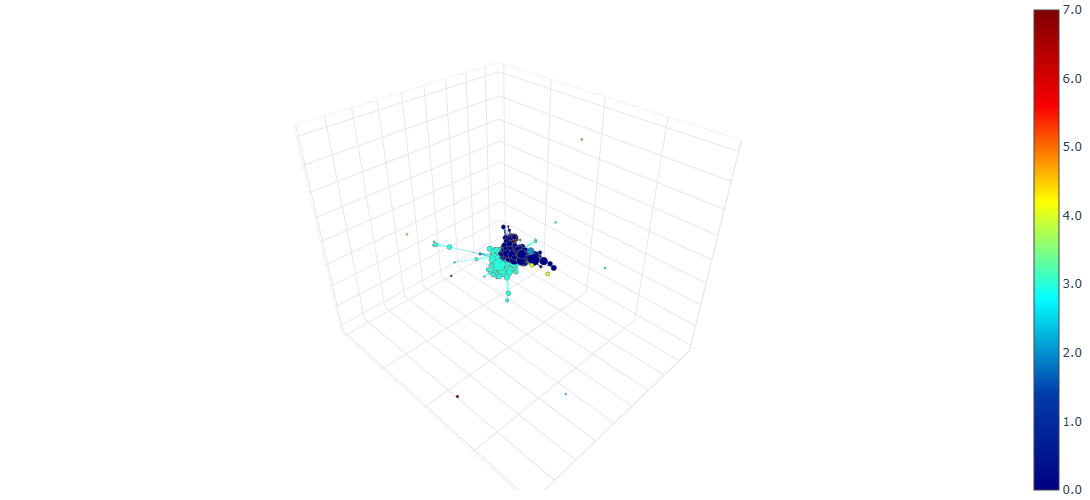

In [24]:
start_time = time.time()

lens1 = PCA(10).fit_transform(X1)

mapper_algo1 = MapperAlgorithm(
    cover = CubicalCover(
        n_intervals = 3,
        overlap_frac = 0.5
    ),
    clustering = FailSafeClustering(
        clustering = AgglomerativeClustering(3, linkage='ward'),
        verbose = False)
)

mapper_graph1 = mapper_algo1.fit_transform(X1, lens1)

end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

mapper_plot1 = MapperLayoutInteractive(
    mapper_graph1,
    colors = dist_df[['color']].to_numpy(),
    cmap = 'jet',
    # agg = np.nanmean,
    agg = most_frequent_nonan,
    dim = 3,
    iterations = 30,
    seed = 5,
    width = 800,
    height = 500)

fig_mean1 = mapper_plot1.plot()
fig_mean1.show(config={'scrollZoom': True})

In [51]:
x = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['x']
y = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['y']
z = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['z']

threeDimData = pd.DataFrame({'x': x, 'y': y, 'z': z})

import re
data_tuple = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['text']

data = []
for item in data_tuple:
    color = int(re.search(r'color: (\d+)', item).group(1))
    node = int(re.search(r'node: (\d+)', item).group(1))
    size = int(re.search(r'size: (\d+)', item).group(1))
    data.append({'color': color, 'node': node, 'size': size})
component_info = pd.DataFrame(data)

full_info = pd.concat([component_info, threeDimData], axis=1)

mp_content_origin = vars(mapper_plot1._MapperLayoutInteractive__graph)['_node']

mp_content = pd.DataFrame.from_dict(mp_content_origin, orient='index')
mp_content.reset_index(inplace=True)
mp_content.rename(columns={'index': 'node'}, inplace=True)

full_info = pd.merge(full_info, mp_content, on=['node', 'size'], how='inner')

In [60]:
color_0 = full_info[full_info['color'] == 0]
color_1 = full_info[full_info['color'] == 3]
color_2 = full_info[full_info['color'] == 7]

count_0 = get_count_dict(color_0)
count_1 = get_count_dict(color_1)
count_2 = get_count_dict(color_2)

full_0 = rbind_data.loc[count_0.keys()]
full_1 = rbind_data.loc[count_1.keys()]
full_2 = rbind_data.loc[count_2.keys()]

lst01 = list(count_0.keys() & count_1.keys())
lst02 = list(count_0.keys() & count_2.keys())
lst12 = list(count_1.keys() & count_2.keys())

full_0 = full_0.drop(lst01, errors='ignore')
full_0 = full_0.drop(lst02, errors='ignore')

full_1 = full_1.drop(lst01, errors='ignore')
full_1 = full_1.drop(lst12, errors='ignore')

full_2 = full_2.drop(lst02, errors='ignore')
full_2 = full_2.drop(lst12, errors='ignore')

In [64]:
lst_regression = [
    '光線名稱',
    '道路類別-第1當事者-名稱',
    '速限-第1當事者', #'道路障礙-視距品質名稱', # 和速限共線
    # '道路型態大類別名稱', # 和事故位置共線
    # '事故位置大類別名稱', 
    # '路面狀況-路面鋪裝名稱', '路面狀況-路面缺陷名稱', '道路障礙-障礙物名稱', # 分類幾乎都是無缺陷
    '號誌-號誌種類名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '事故類型及型態大類別名稱',
]

X, y, p = pval(full_0, full_1, lst_regression)
p

,coefficients,standard_error,wald_statistics,p_value,feature
車道劃分設施-分道設施-路面邊線名稱,-0.808834,0.219151,-3.690763,0.000224,車道劃分設施-分道設施-路面邊線名稱
號誌-號誌種類名稱,-0.910196,0.270601,-3.363610,0.000769,號誌-號誌種類名稱
事故類型及型態大類別名稱,0.427277,0.187244,2.281932,0.022493,事故類型及型態大類別名稱
車道劃分設施-分道設施-快車道或一般車道間名稱,0.253992,0.194294,1.307256,0.191126,車道劃分設施-分道設施-快車道或一般車道間名稱
車道劃分設施-分道設施-快慢車道間名稱,-0.219880,0.193143,-1.138431,0.254941,車道劃分設施-分道設施-快慢車道間名稱
光線名稱,-0.098760,0.167377,-0.590044,0.555161,光線名稱
道路類別-第1當事者-名稱,-0.080332,0.159471,-0.503742,0.614443,道路類別-第1當事者-名稱
車道劃分設施-分向設施大類別名稱,-0.055385,0.183073,-0.302528,0.762250,車道劃分設施-分向設施大類別名稱
速限-第1當事者,-0.080640,0.925071,-0.087172,0.930535,速限-第1當事者


In [66]:
def table(colnames, full_0, full_1):
    
    combined_df = pd.concat([full_0[colnames].value_counts(normalize = True), 
                             full_1[colnames].value_counts(normalize = True),
                            ],
                            axis=1).fillna(0)

    combined_df.columns = ['cluster1', 'cluster2']
    
    return combined_df

table('車道劃分設施-分道設施-路面邊線名稱', full_0, full_1)

,cluster1,cluster2
無,0.675978,0.047619
有,0.324022,0.952381


In [69]:
table('號誌-號誌種類名稱', full_0, full_1)

,cluster1,cluster2
無號誌,0.357542,0.952381
行車管制號誌,0.318436,0.025974
行車管制號誌(附設行人專用號誌),0.173184,0.021645
閃光號誌,0.150838,0.000000
